In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
MY_embeddings = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # 加载一个轻量级的 SBERT 模型

d:\anaconda3\envs\data\envs\py3.11\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


# 这些指标将被用作预测
 - energy_grav: 比能量（重量比），通常单位为Wh/kg。 
 - energy_vol: 体积比能量，通常单位为Wh/L。
 - stability_charge: 充电时的稳定性指标。
 - stability_discharge: 放电时的稳定性指标。

In [3]:
df =  pd.read_csv("battery_material_li.csv")
df.head(4)

,battery_id,battery_formula,working_ion,max_voltage_step,elements,nelements,max_delta_volume,average_voltage,capacity_grav,capacity_vol,energy_grav,energy_vol,stability_charge,stability_discharge,material_ids
0,mp-776296_Li,Li0-1MnPO4,Li,0.000000,"[Element Mn, Element P, Element O]",3,0.106409,3.517563,170.872882,583.222092,601.056170,2051.520590,0.000000,0.037746,"[MPID(mp-777460), MPID(mp-776296)]"
1,mp-26607_Li,Li0-1MnPO4,Li,0.257336,"[Element Mn, Element P, Element O]",3,0.069917,4.307594,170.872882,566.742462,736.050942,2441.296226,0.130776,0.036979,"[MPID(mp-697761), MPID(mp-755395), MPID(mp-266..."
2,mp-754310_Li,Li0-1Fe5(OF2)4,Li,0.000000,"[Element Fe, Element O, Element F]",3,0.041918,4.702296,53.373369,218.995116,250.977395,1029.779927,0.075075,0.050619,"[MPID(mp-754310), MPID(mp-1176720)]"
3,mp-771388_Li,Li0-2MnP2O7,Li,0.447935,"[Element Mn, Element P, Element O]",3,0.165571,3.965911,220.803338,615.484551,875.686392,2440.956960,0.006474,0.029376,"[MPID(mp-771388), MPID(mp-776412), MPID(mp-775..."


In [37]:
# 使用文本预训嵌入将文本数据编码为数组，三个优化方向  1.使用量化的模型提升速度  2.使用用smiles训练的嵌入应该会有更好的性能 3.其它编码方式，这里可以直接独热编码
# 此外这里可以改成池化啥的
def embedding_pca(iter_x,pca_new_dim = 16):
    
    iter_x = MY_embeddings.encode(iter_x)
    # 定义新的维度，例如降到128维
    pca = PCA(n_components=pca_new_dim)
    return pca.fit_transform(iter_x)
battery_formula_embeddings = embedding_pca(df["battery_formula"].values)
elements_embeddings = embedding_pca(df["elements"].values)
working_ion_embeddings = embedding_pca(df["working_ion"].values)

d:\anaconda3\envs\data\envs\py3.11\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


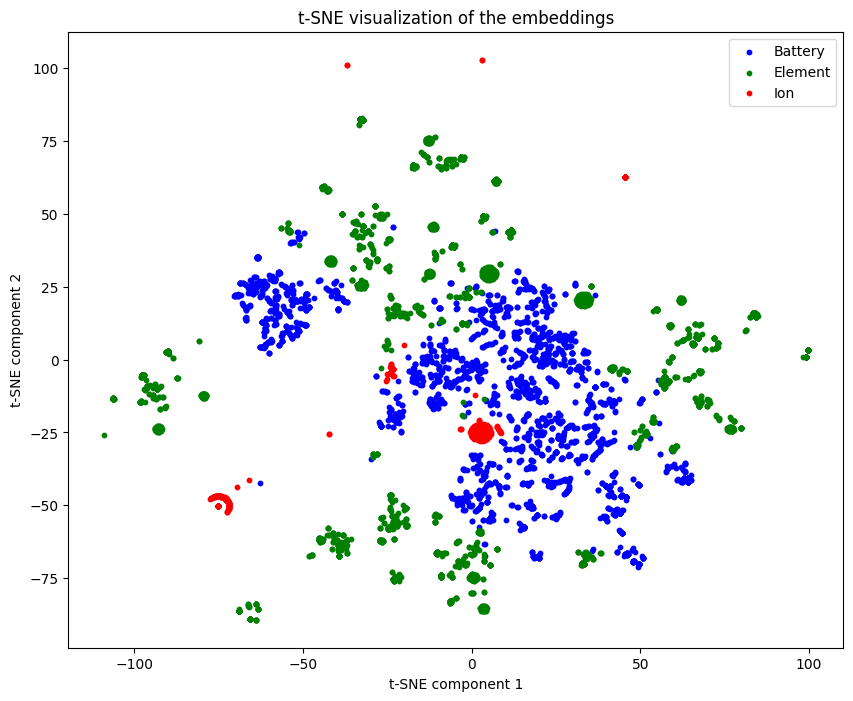

In [38]:
tsne_data = np.concatenate([battery_formula_embeddings,elements_embeddings,working_ion_embeddings])
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 tsne_data 已经定义且形状为 (7320, 16)
# tsne_data = ...

# 假设我们已经知道了每种类型数据的数量
n_battery = battery_formula_embeddings.shape[0]  # battery_formula_embeddings 的样本数量
n_elements = elements_embeddings.shape[0]  # elements_embeddings 的样本数量
n_ions = working_ion_embeddings.shape[0]  # working_ion_embeddings 的样本数量

# 创建标签列表
labels = ['Battery'] * n_battery + ['Element'] * n_elements + ['Ion'] * n_ions

# 设置 t-SNE 参数
n_components = 2  # 我们希望降维到2维以便可视化
perplexity = 30   # 这是一个重要的参数，控制局部与全局结构之间的平衡
learning_rate = 200
n_iter = 1000

# 创建 t-SNE 模型并拟合数据
tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
tsne_results = tsne.fit_transform(tsne_data)

# 使用不同颜色表示不同的类别
plt.figure(figsize=(10, 8))

# 为每个类别选择一种颜色
colors = {'Battery': 'blue', 'Element': 'green', 'Ion': 'red'}

# 绘制散点图
for label in set(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=colors[label], label=label, s=10)

# 添加图例
plt.legend()

# 设置标题和轴标签
plt.title('t-SNE visualization of the embeddings')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# 显示图像
plt.show()

In [39]:
# 第一部分输入  这一部分可以不再作回归分析直接输入到模型里
battery_elements_working_ion_embeddings = np.concatenate([battery_formula_embeddings,elements_embeddings,working_ion_embeddings],axis = 1)
battery_elements_working_ion_embeddings_colums = [f'battery_formula_{i}' for i in range(battery_formula_embeddings.shape[1])] 
battery_elements_working_ion_embeddings_colums += [f'elements_formula_{i}' for i in range(elements_embeddings.shape[1])] 
battery_elements_working_ion_embeddings_colums += [f'working_ion_formula_{i}' for i in range(working_ion_embeddings.shape[1])] 

# 第二部分输入  这一部分应该做一些显著性的相关分析
other_X = df[["nelements","max_delta_volume","average_voltage","capacity_grav","capacity_vol","max_voltage_step"]].values

In [14]:
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
# 定义自变量和因变量
features = ["nelements","max_delta_volume","average_voltage","capacity_grav","capacity_vol","max_voltage_step"]
X = df[features]
y = df['energy_grav']

# 计算VIF值
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif = calculate_vif(X)
print("Initial VIF values:\n", vif)

# 移除VIF值为无穷大的变量
high_vif_features = vif[vif['VIF'] == np.inf]['variables'].tolist()
X = X.drop(columns=high_vif_features)

# 重新计算VIF值以确保没有其他高VIF值
vif = calculate_vif(X)
print("VIF values after removing infinite VIF:\n", vif)

# 再次检查VIF值，如果还有大于10的，可以继续移除
while vif['VIF'].max() > 10:
    feature_to_remove = vif.loc[vif['VIF'].idxmax(), 'variables']
    X = X.drop(columns=[feature_to_remove])
    vif = calculate_vif(X)
    print(f"Removed {feature_to_remove} due to high VIF. Remaining features: {X.columns.tolist()}")

# 使用RFE进行特征选择
model = Ridge(alpha=1.0)
rfe = RFE(model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_]
print("Selected features by RFE:", selected_features)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 拟合岭回归模型并进行交叉验证选择最优alpha
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Best alpha for Ridge:", ridge_cv.alpha_)
print("Ridge Regression R² Score:", r2_score(y_test, y_pred_ridge))

# 拟合LASSO回归模型并进行交叉验证选择最优alpha
lasso_cv = LassoCV(alphas=None, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
print("LASSO Regression MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Best alpha for LASSO:", lasso_cv.alpha_)
print("LASSO Regression R² Score:", r2_score(y_test, y_pred_lasso))

# 输出系数
print("Ridge Coefficients:", ridge_cv.coef_)
print("LASSO Coefficients:", lasso_cv.coef_)

Initial VIF values:
           variables        VIF
0         nelements   5.949477
1  max_delta_volume   1.596850
2   average_voltage   4.251218
3     capacity_grav  29.600326
4      capacity_vol  24.616123
5  max_voltage_step   1.215261
VIF values after removing infinite VIF:
           variables        VIF
0         nelements   5.949477
1  max_delta_volume   1.596850
2   average_voltage   4.251218
3     capacity_grav  29.600326
4      capacity_vol  24.616123
5  max_voltage_step   1.215261
Removed capacity_grav due to high VIF. Remaining features: ['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol', 'max_voltage_step']
Selected features by RFE: Index(['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol',
       'max_voltage_step'],
      dtype='object')
Ridge Regression MSE: 19232.889731144984
Best alpha for Ridge: 10.0
Ridge Regression R² Score: 0.8484703219053116
LASSO Regression MSE: 19187.323469940337
Best alpha for LASSO: 1.6001129451519742
LASSO Reg

In [41]:
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
# 定义自变量和因变量
features = ["nelements","max_delta_volume","average_voltage","capacity_grav","capacity_vol","max_voltage_step"]
X = df[features]
y = df['energy_vol']

# 计算VIF值
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif = calculate_vif(X)
print("Initial VIF values:\n", vif)

# 移除VIF值为无穷大的变量
high_vif_features = vif[vif['VIF'] == np.inf]['variables'].tolist()
X = X.drop(columns=high_vif_features)

# 重新计算VIF值以确保没有其他高VIF值
vif = calculate_vif(X)
print("VIF values after removing infinite VIF:\n", vif)

# 再次检查VIF值，如果还有大于10的，可以继续移除
while vif['VIF'].max() > 10:
    feature_to_remove = vif.loc[vif['VIF'].idxmax(), 'variables']
    X = X.drop(columns=[feature_to_remove])
    vif = calculate_vif(X)
    print(f"Removed {feature_to_remove} due to high VIF. Remaining features: {X.columns.tolist()}")

# 使用RFE进行特征选择
model = Ridge(alpha=1.0)
rfe = RFE(model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_]
print("Selected features by RFE:", selected_features)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 拟合岭回归模型并进行交叉验证选择最优alpha
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Best alpha for Ridge:", ridge_cv.alpha_)
print("Ridge Regression R² Score:", r2_score(y_test, y_pred_ridge))

# 拟合LASSO回归模型并进行交叉验证选择最优alpha
lasso_cv = LassoCV(alphas=None, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
print("LASSO Regression MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Best alpha for LASSO:", lasso_cv.alpha_)
print("LASSO Regression R² Score:", r2_score(y_test, y_pred_lasso))

# 输出系数
print("Ridge Coefficients:", ridge_cv.coef_)
print("LASSO Coefficients:", lasso_cv.coef_)

Initial VIF values:
           variables        VIF
0         nelements   5.949477
1  max_delta_volume   1.596850
2   average_voltage   4.251218
3     capacity_grav  29.600326
4      capacity_vol  24.616123
5  max_voltage_step   1.215261
VIF values after removing infinite VIF:
           variables        VIF
0         nelements   5.949477
1  max_delta_volume   1.596850
2   average_voltage   4.251218
3     capacity_grav  29.600326
4      capacity_vol  24.616123
5  max_voltage_step   1.215261
Removed capacity_grav due to high VIF. Remaining features: ['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol', 'max_voltage_step']
Selected features by RFE: Index(['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol',
       'max_voltage_step'],
      dtype='object')
Ridge Regression MSE: 119092.36820502048
Best alpha for Ridge: 100.0
Ridge Regression R² Score: 0.9142601569497875
LASSO Regression MSE: 135571.85516841538
Best alpha for LASSO: 22.833232985657332
LASSO Re

In [42]:
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
# 定义自变量和因变量
features = ["nelements","max_delta_volume","average_voltage","capacity_grav","capacity_vol","max_voltage_step"]
X = df[features]
y = df['stability_charge']

# 计算VIF值
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif = calculate_vif(X)
print("Initial VIF values:\n", vif)

# 移除VIF值为无穷大的变量
high_vif_features = vif[vif['VIF'] == np.inf]['variables'].tolist()
X = X.drop(columns=high_vif_features)

# 重新计算VIF值以确保没有其他高VIF值
vif = calculate_vif(X)
print("VIF values after removing infinite VIF:\n", vif)

# 再次检查VIF值，如果还有大于10的，可以继续移除
while vif['VIF'].max() > 10:
    feature_to_remove = vif.loc[vif['VIF'].idxmax(), 'variables']
    X = X.drop(columns=[feature_to_remove])
    vif = calculate_vif(X)
    print(f"Removed {feature_to_remove} due to high VIF. Remaining features: {X.columns.tolist()}")

# 使用RFE进行特征选择
model = Ridge(alpha=1.0)
rfe = RFE(model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_]
print("Selected features by RFE:", selected_features)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 拟合岭回归模型并进行交叉验证选择最优alpha
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Best alpha for Ridge:", ridge_cv.alpha_)
print("Ridge Regression R² Score:", r2_score(y_test, y_pred_ridge))

# 拟合LASSO回归模型并进行交叉验证选择最优alpha
lasso_cv = LassoCV(alphas=None, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
print("LASSO Regression MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Best alpha for LASSO:", lasso_cv.alpha_)
print("LASSO Regression R² Score:", r2_score(y_test, y_pred_lasso))

# 输出系数
print("Ridge Coefficients:", ridge_cv.coef_)
print("LASSO Coefficients:", lasso_cv.coef_)

Initial VIF values:
           variables        VIF
0         nelements   5.949477
1  max_delta_volume   1.596850
2   average_voltage   4.251218
3     capacity_grav  29.600326
4      capacity_vol  24.616123
5  max_voltage_step   1.215261
VIF values after removing infinite VIF:
           variables        VIF
0         nelements   5.949477
1  max_delta_volume   1.596850
2   average_voltage   4.251218
3     capacity_grav  29.600326
4      capacity_vol  24.616123
5  max_voltage_step   1.215261
Removed capacity_grav due to high VIF. Remaining features: ['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol', 'max_voltage_step']
Selected features by RFE: Index(['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol',
       'max_voltage_step'],
      dtype='object')
Ridge Regression MSE: 0.2455917977580031
Best alpha for Ridge: 1e-06
Ridge Regression R² Score: -0.0506203601550228
LASSO Regression MSE: 0.24709439416197793
Best alpha for LASSO: 0.0036134008099731655
LAS

In [43]:
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
# 定义自变量和因变量
features = ["nelements","max_delta_volume","average_voltage","capacity_grav","capacity_vol","max_voltage_step"]
X = df[features]
y = df['stability_discharge']

# 计算VIF值
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif = calculate_vif(X)
print("Initial VIF values:\n", vif)

# 移除VIF值为无穷大的变量
high_vif_features = vif[vif['VIF'] == np.inf]['variables'].tolist()
X = X.drop(columns=high_vif_features)

# 重新计算VIF值以确保没有其他高VIF值
vif = calculate_vif(X)
print("VIF values after removing infinite VIF:\n", vif)

# 再次检查VIF值，如果还有大于10的，可以继续移除
while vif['VIF'].max() > 10:
    feature_to_remove = vif.loc[vif['VIF'].idxmax(), 'variables']
    X = X.drop(columns=[feature_to_remove])
    vif = calculate_vif(X)
    print(f"Removed {feature_to_remove} due to high VIF. Remaining features: {X.columns.tolist()}")

# 使用RFE进行特征选择
model = Ridge(alpha=1.0)
rfe = RFE(model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_]
print("Selected features by RFE:", selected_features)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 拟合岭回归模型并进行交叉验证选择最优alpha
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Best alpha for Ridge:", ridge_cv.alpha_)
print("Ridge Regression R² Score:", r2_score(y_test, y_pred_ridge))

# 拟合LASSO回归模型并进行交叉验证选择最优alpha
lasso_cv = LassoCV(alphas=None, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
print("LASSO Regression MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Best alpha for LASSO:", lasso_cv.alpha_)
print("LASSO Regression R² Score:", r2_score(y_test, y_pred_lasso))

# 输出系数
print("Ridge Coefficients:", ridge_cv.coef_)
print("LASSO Coefficients:", lasso_cv.coef_)

Initial VIF values:
           variables        VIF
0         nelements   5.949477
1  max_delta_volume   1.596850
2   average_voltage   4.251218
3     capacity_grav  29.600326
4      capacity_vol  24.616123
5  max_voltage_step   1.215261
VIF values after removing infinite VIF:
           variables        VIF
0         nelements   5.949477
1  max_delta_volume   1.596850
2   average_voltage   4.251218
3     capacity_grav  29.600326
4      capacity_vol  24.616123
5  max_voltage_step   1.215261
Removed capacity_grav due to high VIF. Remaining features: ['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol', 'max_voltage_step']
Selected features by RFE: Index(['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol',
       'max_voltage_step'],
      dtype='object')
Ridge Regression MSE: 0.18573950713809284
Best alpha for Ridge: 1000.0
Ridge Regression R² Score: 0.02013485662598169
LASSO Regression MSE: 0.18486395381778192
Best alpha for LASSO: 0.004218216476625985
LA

In [40]:
other_X = df[['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol', 'max_voltage_step']].values

In [46]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

# 合并两部分输入
X = np.concatenate([battery_elements_working_ion_embeddings, other_X], axis=1)
y = df['energy_grav']

other_columns = ['nelements', 'max_delta_volume', 'average_voltage', 'capacity_vol', 'max_voltage_step']
feature_names = battery_elements_working_ion_embeddings_colums + other_columns
X_df = pd.DataFrame(X, columns=feature_names)


# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 拟合岭回归模型并进行交叉验证选择最优alpha
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Best alpha for Ridge:", ridge_cv.alpha_)
print("Ridge Regression R² Score:", r2_score(y_test, y_pred_ridge))

# 拟合LASSO回归模型并进行交叉验证选择最优alpha
lasso_cv = LassoCV(alphas=None, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
print("LASSO Regression MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Best alpha for LASSO:", lasso_cv.alpha_)
print("LASSO Regression R² Score:", r2_score(y_test, y_pred_lasso))

# 输出系数
print("Ridge Coefficients:", ridge_cv.coef_)
print("LASSO Coefficients:", lasso_cv.coef_)

Ridge Regression MSE: 14184.249750272658
Best alpha for Ridge: 10.0
Ridge Regression R² Score: 0.8882469130370496
LASSO Regression MSE: 14263.781408424293
Best alpha for LASSO: 0.7427066378736659
LASSO Regression R² Score: 0.887620308989165
Ridge Coefficients: [-1.40418404e+01 -7.13629977e+00  1.36646604e+01 -2.15412438e+00
  1.83223713e+01  5.76661139e-01 -2.93157359e+00  1.93582735e+00
 -1.30934316e+01 -1.38374848e+01 -1.05075595e+01 -2.07837722e+00
  8.52811905e+00  2.14088839e+01  1.57323546e+00 -2.30869086e+01
  2.19456385e+01  9.20487044e+00  2.75175639e+01 -2.36651138e+01
  3.83686255e+01  1.89007537e+01  1.31502106e+01 -1.97166251e+01
  1.43986440e+01 -8.86325260e+00 -8.62468992e+00  1.99744302e+01
  1.77103444e+01 -8.76088071e+00  2.20532657e+00  1.77973030e+00
  2.59505440e+00  1.74951886e-01  3.85255486e+00  2.84117674e+00
  1.51816328e+00 -1.70730025e-01  2.89749284e+00  2.90691195e+00
  4.24118108e+00  1.48354145e+00 -5.86954942e-01  5.01045724e+00
  3.19058614e-01 -3.7998